# <span style="color:blue"> Esercitazione 04 </span>

#### NOTA PER IL LETTORE:
A differenza delle precedenti esercitazioni, data l'interconnessione tra le richieste di questa esercitazione la discussione del lavoro viene svolta senza articolazione in sottosezioni. <p>
Inoltre, visto che il codice di dinamica molecolare è stato riutilizzato nelle successive settimane per l'esercitazione 07, si è operata una drastica modifica del codice originario per renderlo speculare a quest'ultimo.

## <span style="color:blue"> Esercizio 4.1 - 4.2 - 4.3 + Esercizio facoltativo 
(code MolDyn_NVE.cpp)


### Scopo dell'esercizio

È richiesto di implementare il codice fornito su Ariel, in primo luogo con la possibilità di *ripartenza* (ovvero di poter sfruttare una configurazione precedente come dato iniziale della simulazione al tempo $-dt$) e, in secondo luogo, con la *blocking average*. Fatto ciò, si chiede di simulare un fluido di Lennard Jones nelle seguenti condizioni termodinamiche:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ ($r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ ($r_c = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ ($r_c = 5.0$).

### Discussione del lavoro

**Ripartenza:** Si sono seguite le istruzioni fornite. Nel file *input.dat* è stata inserita una nuova variabile booleana *oldconf*. Se questa è 0, il programma carica la configurazione al tempo 0 dal file *config.0* e crea quella al tempo $-dt$ generando delle velocità casuali con distribuzione uniforme. Se, invece, oldconf = 1 il programma carica anche una configurazione *old.0*. A partire da quest'ultima, il programma calcola $r(dt)$ facendo un singolo passo dell'algoritmo di Verlet, dopo di che trova il valore delle velocità $v(dt/2)$, le riscala in funzione della temperatura voluta e con esse ricalcola $r(0)$ mantenendo valido il valore ottenuto di $r(dt)$. <p>
Questa procedura è particolamente utile per **equilibrare** il sistema a una temperatura il più vicina possibile a quella che si cerca di simulare, dato che nel Microcanonico la temperatura non è fissata. <span style="color:red"> Si ricorda che l'equilibrazione è la prima fase di ogni simulazione, necessaria perchè il sistema sia veramente all'equilibrio termodinamico e i risultati ottenuti abbiano senso fisico. <p>
Qui sono riportate le immagini dei run di equilibrazione della fase solida. Ogni run consta di 1000 step temporali. È stato calcolato un fit del valore intorno al quale fluttua la temperatura, in modo da capire a spanne quando questo valore raggiunge quello richiesto ed è possibile partire con la simulazione vera e propria. La configurazione iniziale è di tipo FCC. Si osserva che pian piano il crollo verso il basso dell'energia cinetica si smussa e in 6 ripartenze il sistema si stabilizza a una temperatura molto prossima a quella che si vuole simulare.

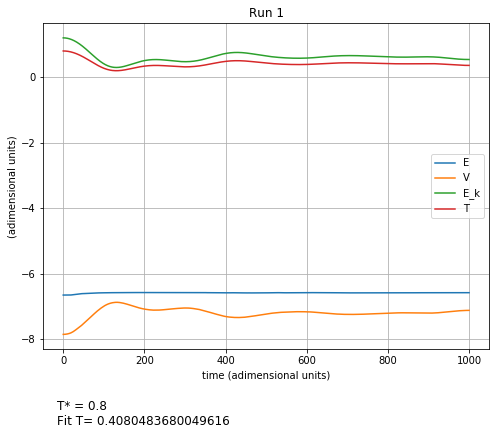 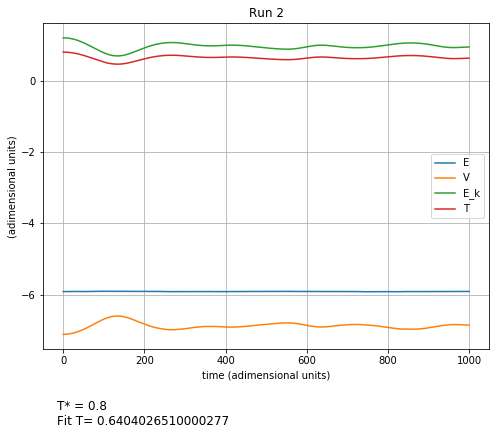 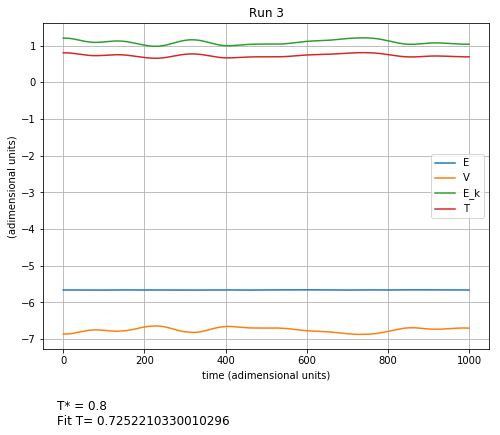 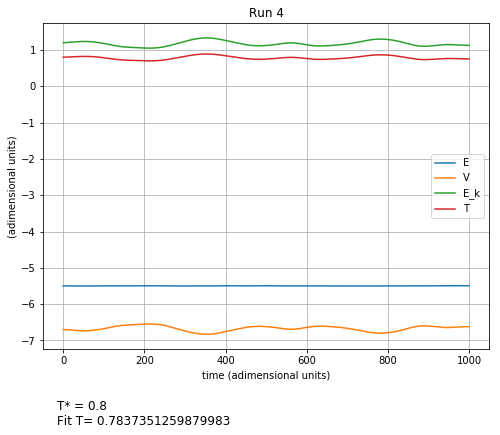 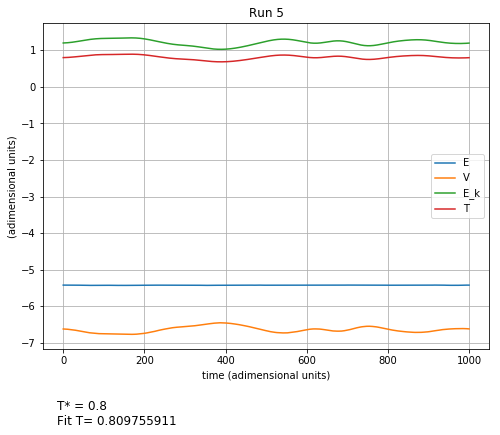 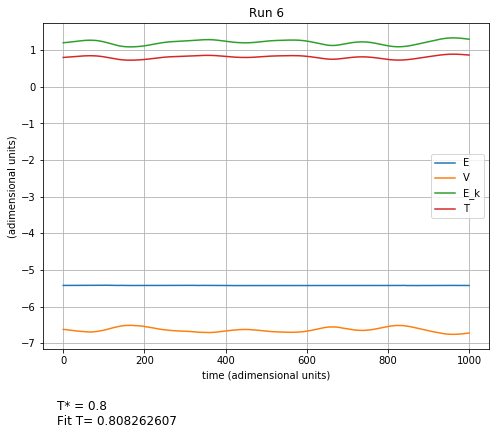

**Metodo a Blocchi:** Inizialmente la struttura data alla blocking average era alquanto diversa, ma dopo l'esercitazione 07 si è implementata la stessa identica procedura di quel codice. Si è inserito un ciclo sui blocchi da *iblk* a *nblk* nel main e il parametro *nstep* ha assunto il significato di numero di step **per blocco**. In ogni ciclo la funzione *Measure* calcola l'energia cinetica, potenziale e il viriale e scrive i valori istantanei nell'array *walker*. I valori istantanei sono salvati su file *output_NOMEGRANDEZZA.dat*. La funzione *Accumulate* somma tra loro i valori del walker a step diversi. Alla fine di ogni blocco, poi, la funzione *Averages* ha il compito di ottenere una stima di blocco delle varie quantità con relativa incertezza statistica, la quale viene scritta su file *ave_NOMEGRANDEZZA.dat* insieme alla media cumulata progressiva. Quando un blocco termina e ne comincia un altro, si è inserita la funzione *Reset* che azzera tutti gli accumulatori. <p>
Si è eliminato lo *sparse averaging* euristico precedentemente introdotto, che stampava solo i risultati ogni 10 passi per ottenere dati più scorrelati tra loro.
    
### <span style="color:red"> Simulazione 1: fase solida
    
Si è già mostrata in precedenza la fase di equilibrazione, ottenuta in 6 rilanci. Il passo successivo è stabilire il **numero di blocchi** in cui dividere il totale degli $M=10^4$ passi della simulazione. Chiaramente l'algoritmo di Verlet che integra le equazioni del moto produce delle configurazioni tra loro correlate, per cui è necessario che i blocchi abbiano una lunghezza minima necessaria affinchè le stime ottenute in ogni blocco siano tra loro indipendenti e si possa applicare con serenità il CLT. A questo livello, non si ha ancora a disposizione un criterio univoco per prendere tale decisione, pertanto si è seguito il seguente ragionamento euristico. Ci si è focalizzati su due grandezze, la temperatura e l'energia potenziale, si è provato a dividere il campione degli $M$ dati in un certo numero $N$ di blocchi e si è fatto un fit a costante su ogni blocco per ottenere un valore rappresentativo per ciascuno. Analizzando graficamente la dispersione di tali valori si è cercato, infine, di capire se questi blocchi potessero essere sufficientemente indipendenti l'uno dall'altro. In particolare si è osservato se stime di blocchi adiacenti fossero più o meno simili. Nel momento in cui stime consecutive si sono rivelate sufficientemente distinte, si è accettato il numero di blocchi ipotizzato. <p>
Nel caso del solido, dopo tutto ciò, la scelta è ricaduta su $N=80$ blocchi (di lunghezza $L=M/N=125$). L'analisi grafica sopra descritta è mostrata nella figura sottostante sui primi 4000 dati generati.

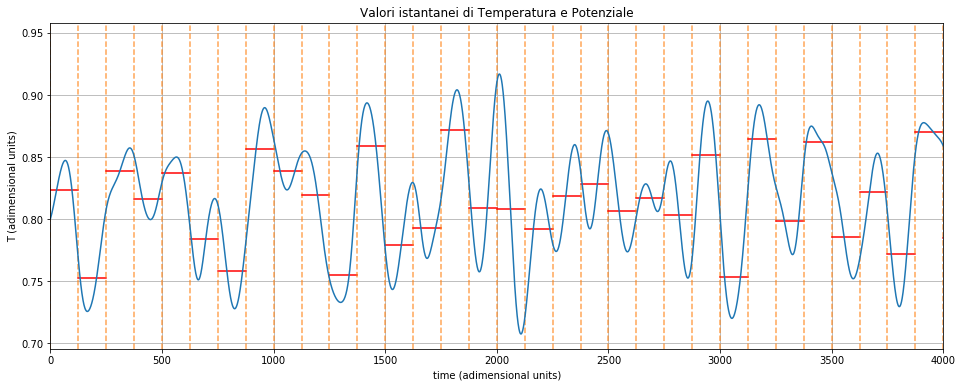

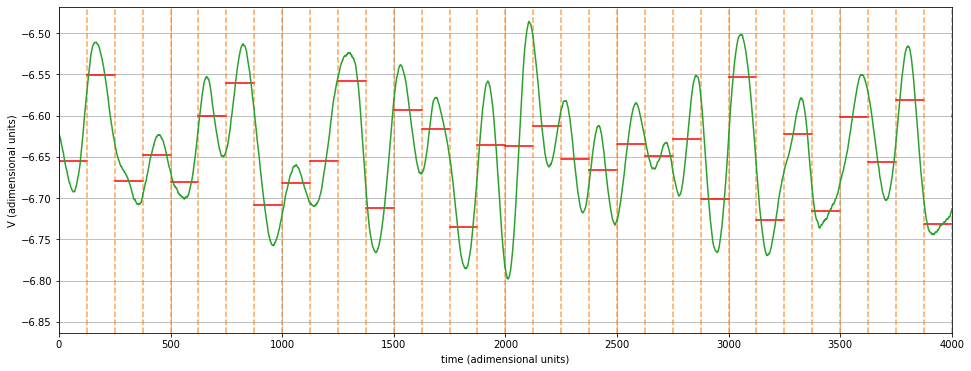

In [9]:
%matplotlib inline
from numpy import *
from math import *
import pylab as plt
from scipy.optimize import curve_fit

def fitfunc(x,c):
    return c

T = genfromtxt('SOLID_output_temp.dat')
x=arange(0,10000,1)
plt.figure(figsize=(16.,6.))
plt.title('Valori istantanei di Temperatura e Potenziale')
plt.xlim(0,4000)

y=arange(0,10000,125)
for p in y:
    plt.axvline(p, linestyle='--', color='C1', alpha=0.7)
    p_opt, p_cov = curve_fit(fitfunc, y[p:p+125], T[p:p+125], bounds=(0.7,0.9))
    plt.plot ([p,p+125], [p_opt[0],p_opt[0]], color='r')

plt.plot(x,T[:], label='T')
plt.xlabel('time (adimensional units)')
plt.ylabel('T (adimensional units)')
plt.grid(True)
plt.show()

V = genfromtxt('SOLID_output_epot.dat')
x=arange(0,10000,1)
plt.figure(figsize=(16.,6.))
plt.xlim(0,4000)

y=arange(0,10000,125)
for p in y:
    plt.axvline(p, linestyle='--', color='C1', alpha=0.7)
    p_opt, p_cov = curve_fit(fitfunc, y[p:p+125], V[p:p+125], bounds=(-6.8,-6.5))
    plt.plot ([p,p+125], [p_opt[0],p_opt[0]], color='r')

plt.plot(x,V[:], label='V', color='C2')
plt.xlabel('time (adimensional units)')
plt.ylabel('V (adimensional units)')
plt.grid(True)
plt.show()

Una volta scelto il numero di blocchi, si hanno a disposizione tutte le informazioni utili per far partire la simulazione vera e propria e si sono graficate le grandezze fisiche di interesse, energia cinetica, potenziale e totale, temperatura e pressione, in funzione del numero di blocchi. <p>
Per ottenere una stima del valore a cui convcergono tali grandezze, nel momento in cui la curva inizia a saturare si è effettuato ancora una volta un fit a costante. Si noti che la temperatura ottenuta è $T_{sim}=97.37 \pm 0.02 \space K$, diversa da quella di target $T=120 \cdot 0.8=96 \space K$ (e ciò ovviamente anche per le altre grandezze). Questo è, purtroppo inevitabile, dato l'insieme microcanonico in cui si lavora. Poichè il fattore dimensionale della temperaura è di ordine $100$, anche una simulazione che equilibri a una temperatura di $0.1$ superiore o inferiore a quella di target porta con sè una distanza di $10\space K$ tra la temperatura simulata e quella voluta.

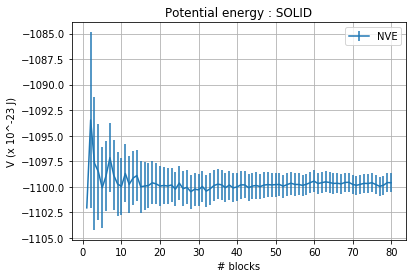

Fit del valore di convergenza      V= -1099.800439200031 \pm 0.0341388547294724  x 10^-23 J


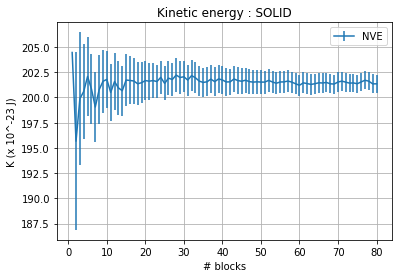

Fit del valore di convergenza      K= 201.5587861714286 \pm 0.032820522069944146  x 10^-23 J


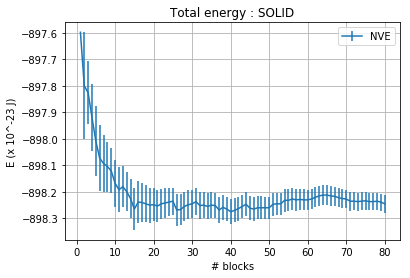

Fit del valore di convergenza      E= -898.2415110857143 \pm 0.0022439232814556523  x 10^-23 J


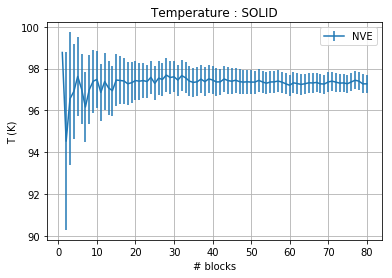

Fit del valore di convergenza      T= 97.37145771428571 \pm 0.015853675875482746  K


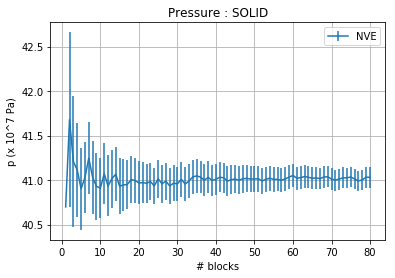

Fit del valore di convergenza      p= 41.00470830194396 \pm 0.003734700144066888 x 10^7 Pa


In [1]:
%matplotlib inline
from numpy import *
from math import *
import pylab as plt
from scipy.optimize import curve_fit

def fitfunc(x,c):
    return c

eps=120*1.38 # per 10^-23 Joule         # SI UNITS
sigma =0.34 #per 10^-9 metres
press= 4.213 # per 10^7 Pa
Temp= 120 #Kelvin

V = genfromtxt('SOLID_ave_epot.dat')
K = genfromtxt('SOLID_ave_ekin.dat')
T = genfromtxt('SOLID_ave_temp.dat')
E = genfromtxt('SOLID_ave_etot.dat')
p = genfromtxt('SOLID_ave_press.dat')

plt.errorbar(V[:,0], eps*V[:,2], yerr=eps*V[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, V[10:,0], eps*V[10:,2], bounds=(-1105,-1095))
plt.title('Potential energy : SOLID')
plt.xlabel('# blocks')
plt.ylabel('V (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()

print('Fit del valore di convergenza      V=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(K[:,0], eps*K[:,2], yerr=eps*K[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, K[10:,0], eps*K[10:,2], bounds=(200,205))
plt.title('Kinetic energy : SOLID')
plt.xlabel('# blocks')
plt.ylabel('K (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      K=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J' )

plt.errorbar(E[:,0], eps*E[:,2], yerr=eps*E[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, E[10:,0], eps*E[10:,2], bounds=(-898.3,-898.1))
plt.title('Total energy : SOLID')
plt.xlabel('# blocks')
plt.ylabel('E (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      E=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(T[:,0], Temp*T[:,2], yerr=Temp*T[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, T[10:,0], Temp*T[10:,2], bounds=(96,100))
plt.title('Temperature : SOLID')
plt.xlabel('# blocks')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      T=',p_opt[0], '\pm', sqrt(p_cov[0]),' K')

plt.errorbar(p[:,0], press*p[:,2], yerr=press*p[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, p[10:,0], press*p[10:,2], bounds=(40.5,42.5))
plt.title('Pressure : SOLID')
plt.xlabel('# blocks')
plt.ylabel('p (x 10^7 Pa)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      p=',p_opt[0], '\pm', sqrt(p_cov[0]), 'x 10^7 Pa')

### <span style="color:red"> Simulazione 2: fase liquida
    
Per le altre due fasi, la procedura è stata la stessa e ci si limita a riportare i risultati ottenuti. <p>
L'**equilibrazione**, per velocizzare il tutto, è stata svolta a partire dalla precedente configurazione solida ottenuta ed è durata anch'essa 6 run da 1000 step l'uno. Il numero di blocchi scelto è $N=50$.

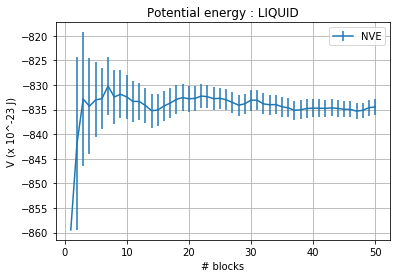

Fit del valore di convergenza      V= -834.8448000000042 \pm 0.06170475438778696  x 10^-23 J


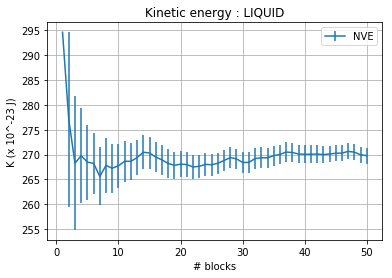

Fit del valore di convergenza      K= 270.1901999999789 \pm 0.06123440700036024  x 10^-23 J


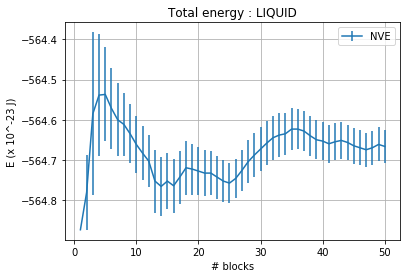

Fit del valore di convergenza      E= -564.6547103999999 \pm 0.003839589835238215  x 10^-23 J


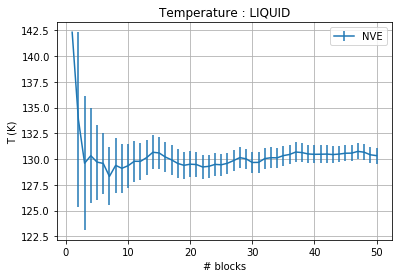

Fit del valore di convergenza      T= 130.52655999921473 \pm 0.029555766176598133  K


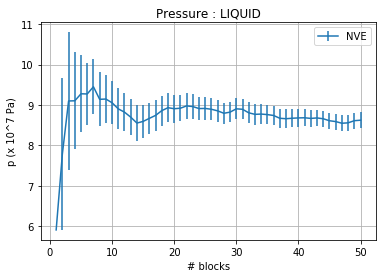

Fit del valore di convergenza      p= 8.644570440000003 \pm 0.01348088276782605 x 10^7 Pa


In [2]:
%matplotlib inline
from numpy import *
from math import *
import pylab as plt
from scipy.optimize import curve_fit

def fitfunc(x,c):
    return c

eps=120*1.38 # per 10^-23 Joule         # SI UNITS
sigma =0.34 #per 10^-9 metres
press= 4.213 # per 10^7 Pa
Temp= 120 #Kelvin

V = genfromtxt('LIQUID_ave_epot.dat')
K = genfromtxt('LIQUID_ave_ekin.dat')
T = genfromtxt('LIQUID_ave_temp.dat')
E = genfromtxt('LIQUID_ave_etot.dat')
p = genfromtxt('LIQUID_ave_press.dat')

plt.errorbar(V[:,0], eps*V[:,2], yerr=eps*V[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, V[35:,0], eps*V[35:,2], bounds=(-840,-830))
plt.title('Potential energy : LIQUID')
plt.xlabel('# blocks')
plt.ylabel('V (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()

print('Fit del valore di convergenza      V=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(K[:,0], eps*K[:,2], yerr=eps*K[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, K[35:,0], eps*K[35:,2], bounds=(265,275))
plt.title('Kinetic energy : LIQUID')
plt.xlabel('# blocks')
plt.ylabel('K (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      K=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J' )

plt.errorbar(E[:,0], eps*E[:,2], yerr=eps*E[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, E[35:,0], eps*E[35:,2], bounds=(-564.8,-564.5))
plt.title('Total energy : LIQUID')
plt.xlabel('# blocks')
plt.ylabel('E (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      E=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(T[:,0], Temp*T[:,2], yerr=Temp*T[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, T[35:,0], Temp*T[35:,2], bounds=(128,132))
plt.title('Temperature : LIQUID')
plt.xlabel('# blocks')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      T=',p_opt[0], '\pm', sqrt(p_cov[0]),' K')

plt.errorbar(p[:,0], press*p[:,2], yerr=press*p[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, p[35:,0], press*p[35:,2], bounds=(8,10))
plt.title('Pressure : LIQUID')
plt.xlabel('# blocks')
plt.ylabel('p (x 10^7 Pa)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      p=',p_opt[0], '\pm', sqrt(p_cov[0]), 'x 10^7 Pa')

### <span style="color:red"> Simulazione 3: fase gassosa
    
L'**equilibrazione** è stata svolta a partire dalla precedente configurazione liquida, ma vista la grande difficoltà nel controllare questa fase, ha avuto una durata di 5 run da 30000 step l'uno. La simulazione è stata allungata di durata a $M=4 \cdot 10^5$ step. Il numero di blocchi scelto è $N=20$.

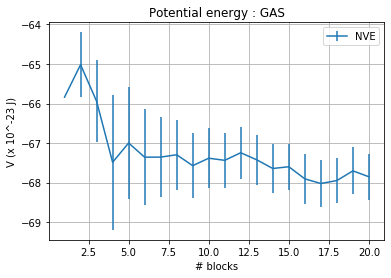

Fit del valore di convergenza      V= -67.67759015999509 \pm 0.08112058900650015  x 10^-23 J


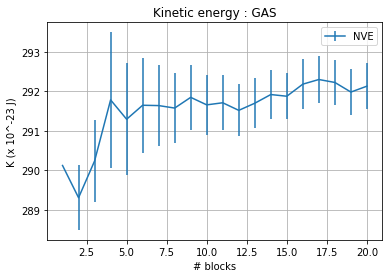

Fit del valore di convergenza      K= 291.9532968000216 \pm 0.08159562725931048  x 10^-23 J


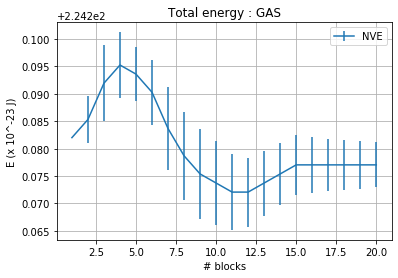

Fit del valore di convergenza      E= 224.2755575974134 \pm 0.0006738018699920195  x 10^-23 J


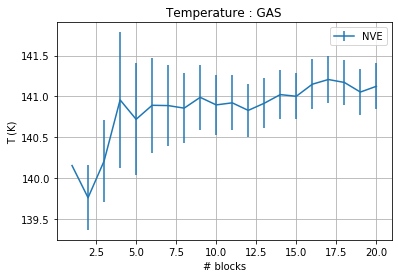

Fit del valore di convergenza      T= 141.04019999919717 \pm 0.03942314041270793  K


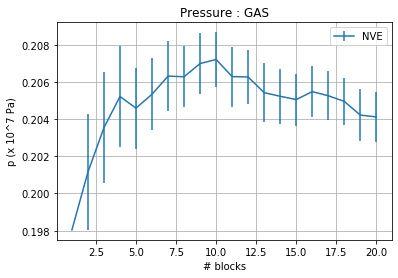

Fit del valore di convergenza      p= 0.2052266114019821 \pm 0.00022746831952276443 x 10^7 Pa


In [3]:
%matplotlib inline
from numpy import *
from math import *
import pylab as plt
from scipy.optimize import curve_fit

def fitfunc(x,c):
    return c

eps=120*1.38 # per 10^-23 Joule         # SI UNITS
sigma =0.34 #per 10^-9 metres
press= 4.213 # per 10^7 Pa
Temp= 120 #Kelvin

V = genfromtxt('GAS_ave_epot.dat')
K = genfromtxt('GAS_ave_ekin.dat')
T = genfromtxt('GAS_ave_temp.dat')
E = genfromtxt('GAS_ave_etot.dat')
p = genfromtxt('GAS_ave_press.dat')

plt.errorbar(V[:,0], eps*V[:,2], yerr=eps*V[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, V[10:,0], eps*V[10:,2], bounds=(-68,-66))
plt.title('Potential energy : GAS')
plt.xlabel('# blocks')
plt.ylabel('V (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()

print('Fit del valore di convergenza      V=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(K[:,0], eps*K[:,2], yerr=eps*K[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, K[10:,0], eps*K[10:,2], bounds=(291,293))
plt.title('Kinetic energy : GAS')
plt.xlabel('# blocks')
plt.ylabel('K (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      K=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J' )

plt.errorbar(E[:,0], eps*E[:,2], yerr=eps*E[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, E[10:,0], eps*E[10:,2], bounds=(224.2+0.065,224.2+0.08))
plt.title('Total energy : GAS')
plt.xlabel('# blocks')
plt.ylabel('E (x 10^-23 J)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      E=',p_opt[0], '\pm', sqrt(p_cov[0]),' x 10^-23 J')

plt.errorbar(T[:,0], Temp*T[:,2], yerr=Temp*T[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, T[10:,0], Temp*T[10:,2], bounds=(140.5,141.5))
plt.title('Temperature : GAS')
plt.xlabel('# blocks')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      T=',p_opt[0], '\pm', sqrt(p_cov[0]),' K')

plt.errorbar(p[:,0], press*p[:,2], yerr=press*p[:,3], label='NVE')
p_opt, p_cov = curve_fit(fitfunc, p[10:,0], press*p[10:,2], bounds=(0.202,0.210))
plt.title('Pressure : GAS')
plt.xlabel('# blocks')
plt.ylabel('p (x 10^7 Pa)')
plt.grid(True)
plt.legend()
plt.show()
print('Fit del valore di convergenza      p=',p_opt[0], '\pm', sqrt(p_cov[0]), 'x 10^7 Pa')